In [317]:
import numpy as np
np.printoptions(precision=2, suppress=True)

def gameTypeToUpperBounds(gameType='5555'):
    UB1 = int(gameType[0])
    UB2 = int(gameType[1])
    UB3 = int(gameType[2])
    UB4 = int(gameType[3])
    return UB1, UB2, UB3, UB4

UB1, UB2, UB3, UB4 = gameTypeToUpperBounds(gameType='5555')
    
def genTokenValues(UB1 = 1, UB2 = 0, UB3 = 0, UB4 = 1, numBuyers=4, numSellers=4, numTokens=4, seed = None):
    if seed != None:
        np.random.seed(seed)
    baseValues = np.random.uniform(0, UB1, (numBuyers + numSellers, numTokens)) 
    agentDifferentiator = np.random.uniform(0, UB2, (numBuyers + numSellers, 1)) 
    tokenDifferentiator = np.random.uniform(0, UB3, (1, numTokens))  
    buyerDifferentiator = np.random.uniform(0, UB4, (numBuyers, 1)) 
    tokenValues = baseValues + agentDifferentiator + tokenDifferentiator + np.r_[buyerDifferentiator, np.zeros((numSellers, 1))]
    normTokenValues = ((tokenValues - tokenValues.min()) / (tokenValues.max() - tokenValues.min())) * 100
    return normTokenValues

tokenValues = genTokenValues(UB1, UB2, UB3, UB4, numBuyers, numSellers, numTokens, seed = 43)

def sortTokens(tokenValues, numBuyers, numSellers):
    buyerValues = tokenValues[0:numBuyers,:]
    descIdx = np.argsort(buyerValues, axis=1)[:,::-1]
    buyerValues = np.take_along_axis(buyerValues, descIdx, axis=1)
    
    sellerCosts = tokenValues[numBuyers:(numBuyers + numSellers), :]
    ascIdx = np.argsort(sellerCosts, axis = 1)
    sellerCosts = np.take_along_axis(sellerCosts, ascIdx, axis=1)
    return buyerValues, sellerCosts

In [303]:
buyerValues, sellerCosts = sortTokens(genTokenValues(seed=3))
buyerValues, sellerCosts

(array([[ 65.89,  56.81,  54.51,  41.82],
        [100.00,  99.81,  60.24,  55.52],
        [ 58.81,  57.89,  35.42,  34.17],
        [ 54.00,  52.44,  49.07,  31.05]]),
 array([[ 0.00, 13.58, 22.57, 30.87],
        [ 7.67, 14.98, 24.03, 38.62],
        [11.42, 16.30, 30.05, 43.65],
        [21.01, 37.42, 52.65, 54.94]]))

In [304]:
def demandSupplySchedules(buyerValues, sellerCosts, granularity = 200, minprice = 0, maxprice = 100):
    prices = np.linspace(minprice, maxprice, granularity)
    demand = np.zeros((granularity), dtype='int')
    supply = np.zeros((granularity), dtype='int')
    for i, price in enumerate(prices):
        demand[i] = np.round(np.sum(price < buyerValues))
        supply[i] = np.round(np.sum(price > sellerCosts))
    return demand, supply, prices

demand, supply, prices = demandSupplySchedules(buyerValues, sellerCosts)
supply, demand

(array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]),
 array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16

In [305]:
def equilibrium(demand,supply,prices):
    clearingPrices, clearingQuantity = [], np.nan
    for i, price in enumerate(prices):
        if demand[i] == supply[i]:
            clearingPrices.append(price)
            clearingQuantity = demand[i]
            
    if len(clearingPrices) == 0: # approximate clearing price
        minDiffIdx = np.argmin(np.abs(demand-supply))
        clearingPrices = prices[minDiffIdx] 
        clearingQuantity = demand[minDiffIdx]

    clearingPrice = np.nanmean(clearingPrices)
    clearingPrice = np.round(clearingPrice,1)
    return np.round(clearingPrice,1), clearingQuantity 

np.set_printoptions(precision=2)

clearingPrice, clearingQuantity  = equilibrium(demand, supply, prices)
clearingPrice, clearingQuantity , clearingQuantity

(40.2, 13, 13)

In [306]:
def reservationPrices(demand, supply,prices):
    demandChangeIdx = np.where(demand[:-1] != demand[1:], 1, 0)
    demandChangeIdx = np.pad(demandChangeIdx, (0,1))
    buyerReservationPrices = prices[demandChangeIdx==1]

    supplyChangeIdx = np.where(supply[:-1] != supply[1:], 1, 0)
    supplyChangeIdx = np.pad(supplyChangeIdx, (0,1))
    sellerReservationPrices = prices[supplyChangeIdx==1]
    return buyerReservationPrices, sellerReservationPrices
    
buyerReservationPrices, sellerReservationPrices = reservationPrices(demand, supply,prices)

In [307]:
buyerReservationPrices

array([30.65, 34.17, 35.18, 41.71, 48.74, 52.26, 53.77, 54.27, 55.28,
       56.78, 57.79, 58.79, 59.80, 65.83, 99.50])

In [308]:
supply

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [309]:
buyerReservationPrices.shape, sellerReservationPrices.shape, np.unique(demand).shape, supply.shape

((15,), (16,), (16,), (200,))

In [310]:
def surplus(buyerValues, sellerCosts, clearingPrice, clearingQuantity):
    buyerSurplus = np.round(np.sum(buyerValues - clearingPrice, where = buyerValues - clearingPrice > 0),1)
    sellerSurplus = np.round(np.sum(clearingPrice - sellerCosts, where = clearingPrice - sellerCosts > 0),1)
    totalSurplus = np.round(buyerSurplus + sellerSurplus)
    buyerSurplusFrac = np.round(buyerSurplus/totalSurplus,1)
    sellerSurplusFrac = np.round(sellerSurplus/totalSurplus,1)
    return buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac

buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac = surplus(buyerValues, sellerCosts, clearingPrice, clearingQuantity)
print(buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac)

284.2 254.1 538.0 0.5 0.5


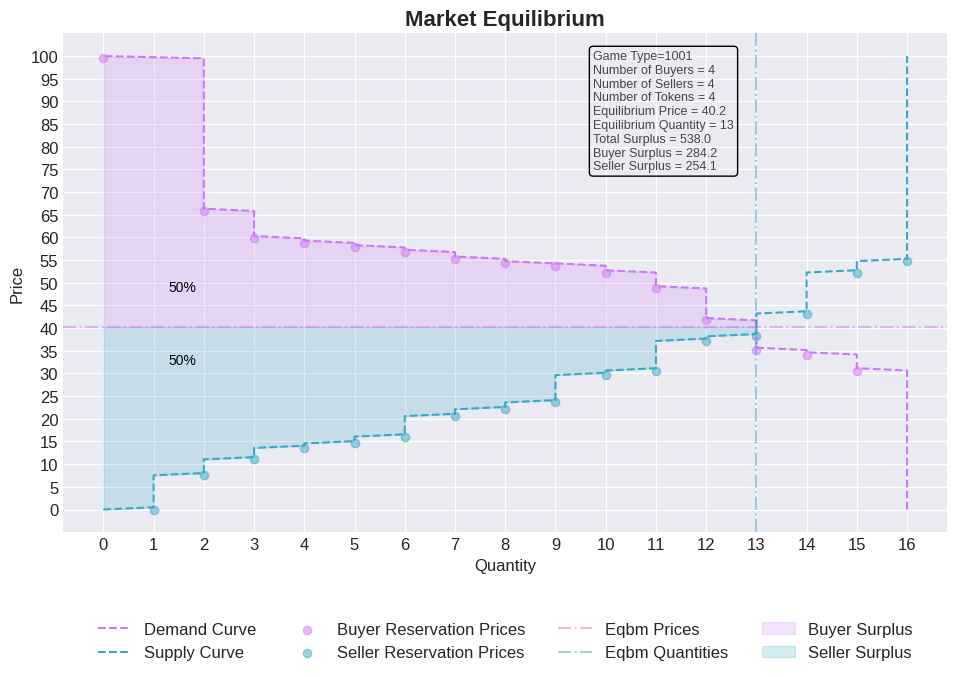

In [311]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def customGraphSettings():
    colors = sns.color_palette("husl", 5)
    plot_settings = {
        'figure.figsize': (10, 7),
        'lines.linestyle': '--',
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'axes.grid': True,  # Add gridlines
        'font.family': 'serif',  # Use a serif font
        'font.size': 12}
    plt.rcParams.update(plot_settings)
    plt.style.use('seaborn-v0_8-darkgrid')
    return colors

def graphMarket(gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps,
                buyerValues, sellerCosts, 
                demand, supply, prices, clearingPrice, clearingQuantity,
                buyerReservationPrices, sellerReservationPrices,
                buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac):

    # plot demand, supply, reservation prices and equilibrium objects
    colors = customGraphSettings()
    fig, ax = plt.subplots() 
    ax.plot(demand, prices, label='Demand Curve', color=colors[4], alpha=1.0) 
    ax.plot(supply, prices, label='Supply Curve', color=colors[3], alpha=1.0) 
    ax.scatter(np.unique(demand)[::-1][1:], buyerReservationPrices, label='Buyer Reservation Prices', marker='o', color=colors[4], alpha=0.5)  # Different color
    ax.scatter(np.unique(supply)[1:], sellerReservationPrices, label='Seller Reservation Prices', marker='o', color=colors[3], alpha=0.5)  # Different color
    ax.axhline(clearingPrice, color=colors[4], alpha = 0.5, label='Eqbm Prices', linestyle='-.')
    ax.axvline(clearingQuantity, color=colors[3], alpha = 0.5, label='Eqbm Quantities', linestyle='-.')

    # Shade buyer and seller surplus
    demand_mask = (demand <= clearingQuantity) 
    supply_mask = (supply <= clearingQuantity)
    ax.fill_between(demand[demand_mask], clearingPrice*np.ones(len(demand[demand_mask])), prices[demand_mask], color=colors[4], alpha=0.2, label='Buyer Surplus')
    ax.fill_between(supply[supply_mask], clearingPrice*np.ones(len(demand[supply_mask])), prices[supply_mask], color=colors[3], alpha=0.2, label='Seller Surplus')
    ax.text(clearingQuantity * 0.1, clearingPrice * 1.2, f'{int(buyerSurplusFrac*100)}%', fontsize=10, color='black')
    ax.text(clearingQuantity * 0.1, clearingPrice * 0.8, f'{int(sellerSurplusFrac*100)}%', fontsize=10, color='black')
    ax.set_xlabel('Quantity')
    ax.set_ylabel('Price')
    
    # Legend and ticks
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()
    ax.xaxis.set_label_position('bottom')
    ax.set_yticks(np.arange(min(prices), max(prices) + 1, 5))
    ax.set_xticks(np.arange(0, max(max(demand), max(supply)) + 1, 1))

    # Information box
    text1 = f'Game Type={gameTypes} \nNumber of Buyers = {numBuyers} \nNumber of Sellers = {numSellers} \nNumber of Tokens = {numTokens}'
    text2 = f'\nEquilibrium Price = {clearingPrice} \nEquilibrium Quantity = {clearingQuantity}'
    text3 = f'\nTotal Surplus = {totalSurplus} \nBuyer Surplus = {buyerSurplus} \nSeller Surplus = {sellerSurplus}'
    ax.text(clearingQuantity*0.75, 75, text1 + text2 + text3, alpha=0.7, fontsize=9, color='black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
    ax.set_title('Market Equilibrium', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig, ax

# Example usage:
fig, ax = graphMarket(gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps,
                      buyerValues, sellerCosts, 
                      demand, supply, prices, clearingPrice, clearingQuantity, 
                      buyerReservationPrices, sellerReservationPrices, 
                      buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac)

plt.show()

In [319]:
def roundSetup(gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed):
    UB1, UB2, UB3, UB4 = gameTypeToUpperBounds(gameType='5555')
    tokenValues = genTokenValues(UB1, UB2, UB3, UB4, numBuyers, numSellers, numTokens, seed = seed)
    buyerValues, sellerCosts = sortTokens(tokenValues, numBuyers, numSellers)
    demand, supply, prices = demandSupplySchedules(buyerValues,sellerCosts)
    clearingPrice, clearingQuantity = equilibrium(demand,supply,prices)
    buyerReservationPrices, sellerReservationPrices = reservePrices(demand, supply,prices)
    buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac = surplus(buyerValues,sellerCosts, clearingPrice, clearingQuantity)

    metadata = []
    metadata += [buyerValues, sellerCosts, demand, supply, prices, clearingPrice, clearingQuantity]
    metadata += [buyerReservationPrices, sellerReservationPrices, buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac]
    return metadata

roundData = roundSetup(gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps)
roundData

['1001',
 4,
 4,
 4,
 4,
 4,
 4,
 array([[ 52.82,  50.93,  50.02,  46.59],
        [ 63.67,  53.61,  53.24,  50.93],
        [100.00,  91.41,  86.83,  80.27],
        [ 79.87,  58.85,  46.25,  29.24]]),
 array([[31.40, 39.96, 56.66, 62.97],
        [36.91, 42.24, 51.99, 59.02],
        [ 7.87, 13.25, 25.97, 32.80],
        [ 0.00,  7.85, 21.70, 23.13]]),
 array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 13, 13, 13, 13, 13, 13, 13, 12, 12,
        10, 10, 10, 10,  8,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,

### Test

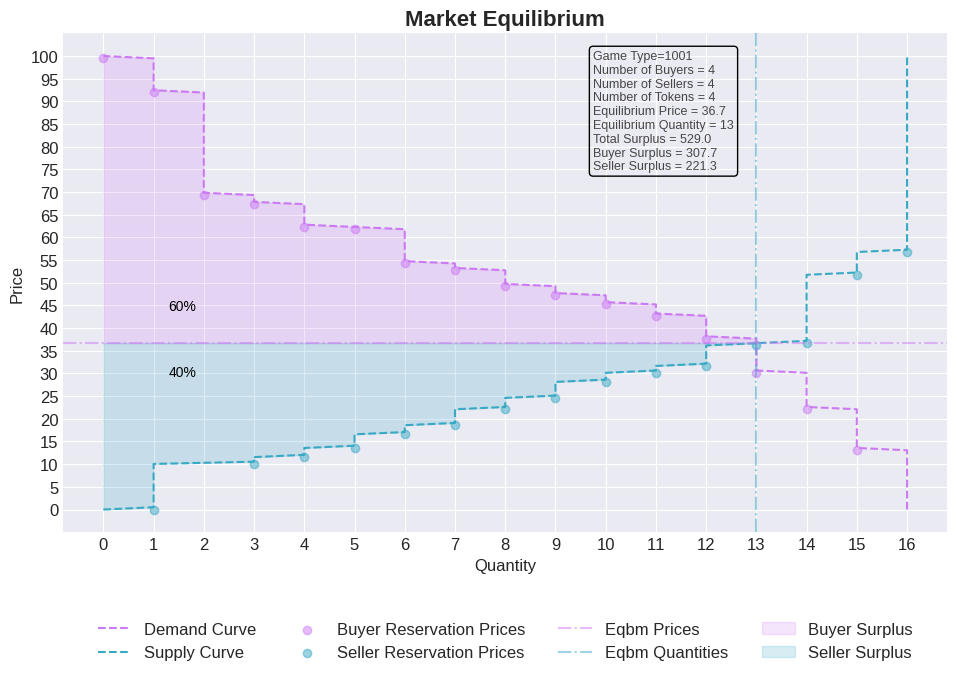

In [2]:
from setup import *
gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed = '1001', 4, 4, 4, 4, 4, 4, 42
gameData = gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed
roundData = roundSetup(*gameData)
fig, ax = graphMarket(*gameData,*roundData)
plt.show()